# Description du MDP et exemple d'utilisation 

In [40]:
using POMDPs
using QuickPOMDPs
using Distributions
using Distributions: DiscreteUniform, pdf
using POMDPTools: Deterministic
using POMDPTools
using Statistics
using POMDPs: states, actions, transition, reward
using TabularTDLearning
using Random
using StatsBase: Weights
using Plots
using DataFrames
using POMDPs
using JuMP
using GLPK

In [19]:
const MAX_INVENTORY = 20
const MAX_STORE = 10
const ORDER_SIZE = 5

const holding_cost_store = 2
const holding_cost_parking = 4
const order_cost = 20
const stockout_penalty = 50

const demand_dist = DiscreteUniform(0, 10)

mdp = QuickMDP(
    
    states = 0:MAX_INVENTORY,
    actions = [0, 1],
    discount = 0.99,

    gen = function (s, a, rng)
        order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
        new_stock = s + order_qty

        d = rand(rng, demand_dist)
        sold = min(d, new_stock)
        sp = new_stock - sold

        lost_sales = max(d - new_stock, 0)

        in_store = min(sp, MAX_STORE)
        in_parking = max(sp - MAX_STORE, 0)

        cost = 0
        cost += a == 1 ? order_cost : 0
        cost += in_store * holding_cost_store
        cost += in_parking * holding_cost_parking
        cost += lost_sales * stockout_penalty

        r = -cost

        return (sp, r, d)
    end,
    initialstate = Deterministic(10)
)


QuickMDP{Base.UUID("d321fa94-6fc0-41f1-b943-870de03db5fa"), Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, actionindex::Dict{Int64, Int64}, initialstate::Deterministic{Int64}, states::UnitRange{Int64}, actions::Vector{Int64}, discount::Float64, gen::var"#41#42"}}((stateindex = Dict(5 => 6, 16 => 17, 7 => 8, 20 => 21, 12 => 13, 8 => 9, 17 => 18, 1 => 2, 19 => 20, 0 => 1…), isterminal = false, actionindex = Dict(0 => 1, 1 => 2), initialstate = Deterministic{Int64}(10), states = 0:20, actions = [0, 1], discount = 0.99, gen = var"#41#42"()))

In [20]:
rng = MersenneTwister(42)
s = 8
a = 1
for i in 1:10
    sp, r, d = POMDPs.gen(mdp, s, a, rng)
    println("From $s --(a=$a)--> $sp,  Demand: $d, Reward = $r")
end


From 8 --(a=1)--> 11,  Demand: 2, Reward = -44
From 8 --(a=1)--> 4,  Demand: 9, Reward = -28
From 8 --(a=1)--> 9,  Demand: 4, Reward = -38
From 8 --(a=1)--> 6,  Demand: 7, Reward = -32
From 8 --(a=1)--> 6,  Demand: 7, Reward = -32
From 8 --(a=1)--> 6,  Demand: 7, Reward = -32
From 8 --(a=1)--> 3,  Demand: 10, Reward = -26
From 8 --(a=1)--> 5,  Demand: 8, Reward = -30
From 8 --(a=1)--> 11,  Demand: 2, Reward = -44
From 8 --(a=1)--> 12,  Demand: 1, Reward = -48


In [5]:
function train_q_learning_agent(mdp, alpha::Float64, epsilon::Float64; iterations=10_000)
    ql = QLearningSolver(
        max_iterations=iterations,
        alpha=alpha,
        epsilon=epsilon,
        gamma=mdp.discount
    )
    policy = solve(ql, mdp)
    return policy, ql.q
end

train_q_learning_agent (generic function with 1 method)

In [21]:
function ε_greedy_action(Q, s, actions, ε)
    if rand() < ε
        return rand(actions)
    else
        return argmax(a -> Q[s][a], actions)
    end
end

ε_greedy_action (generic function with 1 method)

In [22]:
function sarsa_learn(mdp, α, ε, γ=0.99; episodes=10_000, max_steps=100)
    sta = collect(states(mdp))
    ac = collect(actions(mdp))
    function sarsa_learn(mdp, α, ε, γ=0.99; episodes=10_000, max_steps=100)
        sta = collect(states(mdp))
        ac = collect(actions(mdp))
    
        Q = Dict(s => Dict(a => 0.0 for a in ac) for s in sta)
        rng = MersenneTwister(42)
    
        for ep in 1:episodes
            s = rand(rng, sta)
            a = ε_greedy_action(Q, s, ac, ε)
    
            for step in 1:max_steps
                transitions = transition(mdp, s, a)
                probs = [p for (_, p) in transitions]
                next_states = [sp for (sp, _) in transitions]
                s′ = sample(rng, next_states, Weights(probs))
    
                r = reward(mdp, s, a, s′)
                a′ = ε_greedy_action(Q, s′, ac, ε)
    
                Q[s][a] += α * (r + γ * Q[s′][a′] - Q[s][a])
                s, a = s′, a′
            end
        end
    
        policy = Dict(s => argmax(a -> Q[s][a], ac) for s in sta)
        return policy, Q
    end
    
    Q = Dict(s => Dict(a => 0.0 for a in ac) for s in sta)
    rng = MersenneTwister(42)

    for ep in 1:episodes
        s = rand(rng, sta)
        a = ε_greedy_action(Q, s, ac, ε)

        for step in 1:max_steps
            sp, r, _ = gen(mdp, s, a, rng)  # ← NEW: uses gen instead of transition + reward

            # Choose next action a′
            a′ = ε_greedy_action(Q, sp, ac, ε)

            # SARSA update
            Q[s][a] += α * (r + γ * Q[sp][a′] - Q[s][a])

            # Move to next state-action pair
            s, a = sp, a′
        end
    end

    policy = Dict(s => argmax(a -> Q[s][a], ac) for s in sta)
    return policy, Q
end

sarsa_learn (generic function with 2 methods)

In [23]:
policy, Q = sarsa_learn(mdp, 0.9, 0.9)

println("SARSA Policy:")
for st in sort(collect(keys(policy)))
    println("Inventory $st → Action: ", policy[st] == 1 ? "Order" : "Do Not Order")
end

SARSA Policy:
Inventory 0 → Action: Order
Inventory 1 → Action: Order
Inventory 2 → Action: Order
Inventory 3 → Action: Do Not Order
Inventory 4 → Action: Order
Inventory 5 → Action: Order
Inventory 6 → Action: Order
Inventory 7 → Action: Order
Inventory 8 → Action: Do Not Order
Inventory 9 → Action: Order
Inventory 10 → Action: Order
Inventory 11 → Action: Order
Inventory 12 → Action: Order
Inventory 13 → Action: Order
Inventory 14 → Action: Order
Inventory 15 → Action: Order
Inventory 16 → Action: Order
Inventory 17 → Action: Order
Inventory 18 → Action: Do Not Order
Inventory 19 → Action: Do Not Order
Inventory 20 → Action: Do Not Order


In [28]:
function evaluate_policy(mdp, policy; episodes=100, max_steps=100)
    total_reward = 0.0
    rng = MersenneTwister(123)

    for _ in 1:episodes
        s = 10  # initial inventory level (as per problem)
        r_total = 0.0

        for _ in 1:max_steps
            a = policy[s]
            s′, r, _ = gen(mdp, s, a, rng)  # ← use gen() instead of transition + reward
            r_total += r
            s = s′
        end

        total_reward += r_total
    end

    return total_reward / episodes
end


evaluate_policy (generic function with 1 method)

In [29]:
alphas = [0.2, 0.1, 0.01, 1e-5]
epsilons = [0.2, 0.1, 0.01, 1e-5]

results = []

for α in alphas, ε in epsilons
    println("Training SARSA with α = $α, ε = $ε")
    policy, Q = sarsa_learn(mdp, α, ε)
    avg_reward = evaluate_policy(mdp, policy)
    push!(results, (α, ε, round(avg_reward, digits=2)))
end

println("\nPerformance Summary (Average Reward per Policy):")
println("α\tϵ\tAverage Reward")
for (α, ε, reward) in results
    println("$α\t$ε\t$reward")
end

Training SARSA with α = 0.2, ε = 0.2
Training SARSA with α = 0.2, ε = 0.1
Training SARSA with α = 0.2, ε = 0.01
Training SARSA with α = 0.2, ε = 1.0e-5
Training SARSA with α = 0.1, ε = 0.2
Training SARSA with α = 0.1, ε = 0.1
Training SARSA with α = 0.1, ε = 0.01
Training SARSA with α = 0.1, ε = 1.0e-5
Training SARSA with α = 0.01, ε = 0.2
Training SARSA with α = 0.01, ε = 0.1
Training SARSA with α = 0.01, ε = 0.01
Training SARSA with α = 0.01, ε = 1.0e-5
Training SARSA with α = 1.0e-5, ε = 0.2
Training SARSA with α = 1.0e-5, ε = 0.1
Training SARSA with α = 1.0e-5, ε = 0.01
Training SARSA with α = 1.0e-5, ε = 1.0e-5

Performance Summary (Average Reward per Policy):
α	ϵ	Average Reward
0.2	0.2	-4935.9
0.2	0.1	-4888.6
0.2	0.01	-4820.4
0.2	1.0e-5	-4814.66
0.1	0.2	-4896.84
0.1	0.1	-4814.66
0.1	0.01	-4814.66
0.1	1.0e-5	-4814.66
0.01	0.2	-5082.76
0.01	0.1	-5009.14
0.01	0.01	-4920.42
0.01	1.0e-5	-4833.32
1.0e-5	0.2	-4876.08
1.0e-5	0.1	-6278.98
1.0e-5	0.01	-7010.54
1.0e-5	1.0e-5	-6627.0


In [30]:
df = DataFrame(results, [:alpha, :epsilon, :avg_reward])
alphas = sort(unique(df.alpha))
epsilons = sort(unique(df.epsilon))

# Build Z matrix safely
Z = fill(NaN, length(alphas), length(epsilons))
for (i, α) in enumerate(alphas)
    for (j, ϵ) in enumerate(epsilons)
        row = filter(r -> r.alpha == α && r.epsilon == ϵ, eachrow(df))
        if !isempty(row)
            Z[i, j] = row[1][:avg_reward]
        end
    end
end


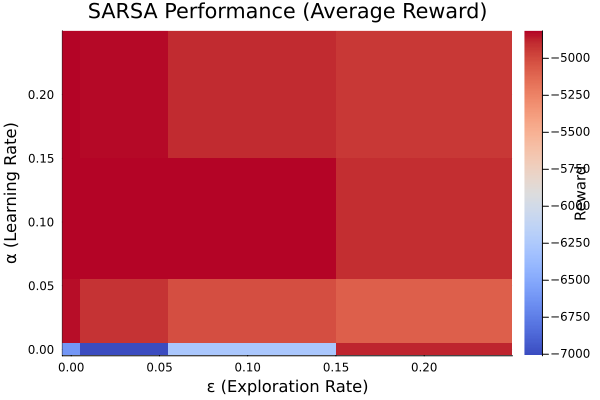

In [31]:
heatmap(
    epsilons,
    alphas,
    Z;
    xlabel = "ε (Exploration Rate)",
    ylabel = "α (Learning Rate)",
    title = "SARSA Performance (Average Reward)",
    colorbar_title = "Reward",
    c = :coolwarm,
    clims = (minimum(Z), maximum(Z))  # adjust color scaling
)


# The value iteration algorithm to find the optimal policy

In [32]:
function value_iteration_gen(mdp; γ=POMDPs.discount(mdp), θ=1e-3, max_iter=100000, n_samples=100)
    states = collect(POMDPs.states(mdp))
    actions_per_state = Dict(s => collect(POMDPs.actions(mdp, s)) for s in states)

    V = Dict(s => 0.0 for s in states)
    π = Dict(s => first(actions_per_state[s]) for s in states)

    rng = Random.MersenneTwister(42)  # fixe pour reproductibilité

    for iter in 1:max_iter
        Δ = 0.0
        V_new = copy(V)

        for s in states
            v_old = V[s]
            best_value = -Inf
            best_action = nothing

            for a in actions_per_state[s]
                total = 0.0
                for _ in 1:n_samples
                    sp, r, _ = POMDPs.gen(mdp, s, a, rng)
                    total += r + γ * V[sp]
                end
                value = total / n_samples

                if value > best_value
                    best_value = value
                    best_action = a
                end
            end

            V_new[s] = best_value
            π[s] = best_action
            Δ = max(Δ, abs(v_old - best_value))
        end

        V = V_new
        if Δ < θ
            println("Convergence atteinte (Δ < θ = $θ).")
            break
        end
    end

    return V, π
end


value_iteration_gen (generic function with 1 method)

In [33]:
V_opt, π_opt = value_iteration_gen(mdp)
for s in sort(collect(keys(π_opt)))
    println("Stock $s → Action optimale : ", π_opt[s] == 1 ? "Commander" : "Ne rien faire")
end


Stock 0 → Action optimale : Commander
Stock 1 → Action optimale : Commander
Stock 2 → Action optimale : Commander
Stock 3 → Action optimale : Commander
Stock 4 → Action optimale : Commander
Stock 5 → Action optimale : Commander
Stock 6 → Action optimale : Commander
Stock 7 → Action optimale : Commander
Stock 8 → Action optimale : Commander
Stock 9 → Action optimale : Commander
Stock 10 → Action optimale : Commander
Stock 11 → Action optimale : Commander
Stock 12 → Action optimale : Commander
Stock 13 → Action optimale : Commander
Stock 14 → Action optimale : Ne rien faire
Stock 15 → Action optimale : Ne rien faire
Stock 16 → Action optimale : Ne rien faire
Stock 17 → Action optimale : Ne rien faire
Stock 18 → Action optimale : Ne rien faire
Stock 19 → Action optimale : Ne rien faire
Stock 20 → Action optimale : Ne rien faire


# The linear programming formulation to find the optimal policy

In [41]:
states = 0:MAX_INVENTORY
actions = [0, 1]
γ = discount(mdp)

function transition(s, a)
    outcomes = []
    order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
    new_stock = s + order_qty

    for d in support(demand_dist)
        sold = min(d, new_stock)
        sp = new_stock - sold
        prob = pdf(demand_dist, d)
        push!(outcomes, (sp, prob, d))
    end
    return outcomes
end

function reward(s, a, sp, d)
    order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
    new_stock = s + order_qty

    lost_sales = max(d - new_stock, 0)
    in_store = min(sp, MAX_STORE)
    in_parking = max(sp - MAX_STORE, 0)

    cost = 0
    cost += a == 1 ? order_cost : 0
    cost += in_store * holding_cost_store
    cost += in_parking * holding_cost_parking
    cost += lost_sales * stockout_penalty

    return -cost
end


ErrorException: cannot assign a value to imported variable POMDPs.states from module Main

In [42]:
model = Model(GLPK.Optimizer)
@variable(model, v[s in states])  # v(s) pour chaque état

# Contraintes : Bellman optimality
for s in states
    for a in actions
        expected_value = 0.0
        for (sp, prob, d) in transition(s, a)
            r = reward(s, a, sp, d)
            expected_value += prob * (r + γ * v[sp])
        end
        @constraint(model, v[s] ≥ expected_value)
    end
end

# Objectif : minimiser somme pondérée (α(s) = 1 ∀s)
@objective(model, Min, sum(v[s] for s in states))

optimize!(model)

# Valeur optimale pour chaque état
V_lp = Dict(s => JuMP.value(v[s]) for s in states)



MethodError: MethodError: no method matching length(::typeof(states))
The function `length` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  length(!Matched::Plots.PlotText)
   @ Plots ~/.julia/packages/Plots/Ec1L1/src/components.jl:378
  length(!Matched::MathOptInterface.Nonlinear.ReverseAD.Coloring.IndexedSet)
   @ MathOptInterface ~/.julia/packages/MathOptInterface/MQX8C/src/Nonlinear/ReverseAD/Coloring/Coloring.jl:47
  length(!Matched::StructTypes.SubTypeClosure)
   @ StructTypes ~/.julia/packages/StructTypes/PaLwj/src/StructTypes.jl:598
  ...


In [36]:
π_lp = Dict()

for s in states
    best_value = -Inf
    best_action = nothing
    for a in actions
        total = 0.0
        for (sp, prob, d) in transition(s, a)
            r = reward(s, a, sp, d)
            total += prob * (r + γ * V_lp[sp])
        end
        if total > best_value
            best_value = total
            best_action = a
        end
    end
    π_lp[s] = best_action
end

println("📊 Politique optimale obtenue par programmation linéaire :")
for s in states
    println("Stock $s → ", π_lp[s] == 1 ? "Commander" : "Ne rien faire")
end


MethodError: MethodError: no method matching iterate(::typeof(states))
The function `iterate` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  iterate(!Matched::Plots.NaNSegmentsIterator)
   @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:175
  iterate(!Matched::Plots.NaNSegmentsIterator, !Matched::Int64)
   @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:175
  iterate(!Matched::MathOptInterface.Utilities.ChainedIteratorAtIndex)
   @ MathOptInterface ~/.julia/packages/MathOptInterface/MQX8C/src/Utilities/functions.jl:699
  ...
